In [326]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.io.wavfile, scipy.fft, scipy.signal, scipy.stats
import IPython

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# ~ General strategy

We're using a Fourier Transform based strategy where we break the audio into small segments and look at the FT of each segment to determine which note is being played in each. Currently, our approach doesn't generalize well to polyphonic music and is limited to pieces with one note being played at a time.

Before running on actual music, we "train" on a chromatic scale and save the FTs of each note in the scale. We'll use these FTs as reference points when trying to detect pitch. Going through this "training" instead of using a fixed frequency-to-note mapping can help to calibrate to the specific timbre and tuning of different instruments.

# I. Note onset detection

We want to find the timestamps of the start of each note (this is only used for the training phase, when we break the chromatic scale down into individual notes).

As an example, there are nine notes in this clip (Beethoven Piano Sonata No. 31, 3rd mvt., fugue theme), and we want to mark the onset of each of these.

In [539]:
sample_file = 'yamaha/LvB_fugue_theme.wav'
IPython.display.Audio(sample_file)

Our approach involves picking out peaks in the raw audio waveform. Since each note produces a new sound, this tends to correlate to a spike in the audio. We're interested in these macro-level peaks:

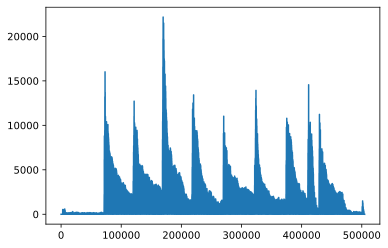

In [550]:
sample_rate, data = scipy.io.wavfile.read(sample_file)
data = np.abs(data)
plt.plot(data);

But there are many other peaks (on the "micro"-level) caused by the sinusoidal nature of sound. We can see these micro-level peaks if we zoom in on a small part of the audio:

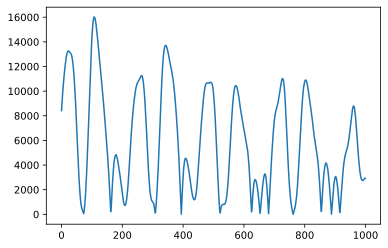

In [551]:
plt.plot(data[73000:74000]);

We want to work with a "zoomed out" version the audio so that we only see the macro-level peaks and ignore the micro-level ones. To do this, we can slide a window over the waveform, take the maximum amplitude of the audio within that window, and discard the rest of the data. This achieves "zooming out" in a sense by hiding the micro-level movements in the waveform and keeps only the general, macro trend.

The `condensed()` function performs this step, returning the condensed data (orange line in the graph below) as well as timestamps in the original audio corresponding to the maximums of each window to be used later (green dots in the graph below).

In [552]:
def condensed(data, window_size):
    padded = np.pad(data, (0, (window_size - len(data) % window_size) % window_size))
    reshaped = padded.reshape((-1, window_size))
    return reshaped.max(axis = 1), reshaped.argmax(axis = 1) + np.arange(0, len(data), window_size)

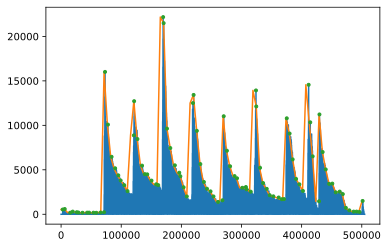

In [553]:
c_window = 5500
c, i = condensed(data, c_window)
plt.plot(data)
plt.plot(np.arange(0, len(data), c_window), c)
plt.plot(i, data[i], '.');

Finally, we can pick out the peaks from the orange line (keeping only ones that are above a certain threshold) and, if necessary, merge adjacent peaks that are too close together.

In [554]:
def get_peaks(data, threshold, condense_window):
    data, peaks = condensed(np.abs(data), condense_window)
    for i in range(1, len(data) - 1):
        if (data[i-1] < data[i] > data[i+1] and data[i] > threshold):
            yield peaks[i]

In [555]:
def merge_peaks(peaks, merge_window):
    prev = -merge_window
    for p in peaks:
        if p >= prev + merge_window:
            yield p
        prev = p

Final result for onset detection:

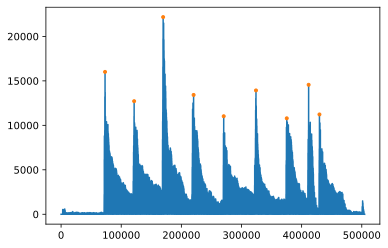

In [556]:
thresh = 5000
plt.plot(data)
markers = list(merge_peaks(get_peaks(data, threshold = thresh, condense_window = c_window), 
                           merge_window = c_window * 2))
plt.plot(markers, data[markers], '.');

# II. Finding reference FTs

We take the chromatic scale and find the Fourier Transform of each note in it, storing the results in the list `notes`.

The Fourier Transforms are cut off after a certain frequency above which there shouldn't be much activity for musical notes in a reasonable range.

In [579]:
def fourier_transform(data, cutoff):
    return scipy.fft.fft(data)[:cutoff]

In [580]:
def get_fts(data, pos, window_size, cutoff):
    return [fourier_transform(data[x:x+window_size], cutoff) for x in pos]

In [599]:
ft_window_hz = 8 # i.e. the window passed to Fourier spans 1/8 of a second
freq_max = 5000 # maximum frequency to include in FTs
training_data = 'yamaha/med.wav'

In [596]:
sample_rate, data = scipy.io.wavfile.read(training_data)
ft_window_size = sample_rate // ft_window_hz
freq_cutoff_index = freq_max // ft_window_hz

In [597]:
onsets = list(merge_peaks(get_peaks(data, threshold = thresh, condense_window = c_window), 
                          merge_window = 2 * c_window))
notes = get_fts(data, onsets, ft_window_size, freq_cutoff_index)
freqs = scipy.fft.fftfreq(ft_window_size, d = 1 / sample_rate)[:freq_cutoff_index]

The resulting FT for the first note in the scale (C3):

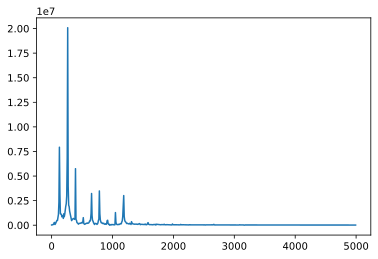

In [600]:
plt.plot(freqs, np.abs(notes[0]));

We're mostly interested in the peaks in the above graph (representing the fundamental frequency of 131 Hz and its overtones), so we want to produce a "sharpened" version of this FT containing only these peaks.

We can reuse the peak-picking function `get_peaks()` used in onset detection:

In [604]:
def normalized(data):
    return data / np.max(data)

In [612]:
def ft_peaks(data, thresh = 0.02, window = 5):
    return list(merge_peaks(get_peaks(data, threshold = thresh, condense_window = window), 
                            merge_window = window))

In [613]:
def sharpened(data):
    peaks = ft_peaks(data)
    sharp = np.zeros(data.shape)
    sharp[peaks] = data[peaks]
    return sharp

In [614]:
ref_fts = [sharpened(normalized(np.abs(ft))) for ft in notes]
ref_mags = np.sum(np.square(ref_fts), axis = 1)

Result after sharpening (of the same note C3):

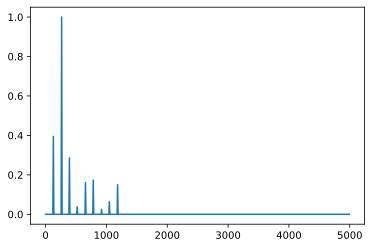

In [616]:
plt.plot(freqs, ref_fts[0]);

# III. Putting everything to use: note detection

For the given audio clip, we can slide a small window over it and find the FT of each window. We then compare this FT with the `ref_fts` to find the most likely note. We're treating the FT of this window as a vector $\mathbf{v}$ and finding the reference FT $\mathbf{r}$ that matches its direction the most (maximizing $\frac{\mathbf{v} \cdot \mathbf{r}}{\| \mathbf{r} \|}$).

Notes that are an octave apart are harder to distinguish, so we add an "octave correction" step afterwards. This step finds the most prominent frequency in the FT (including its overtones) and compares it to the frequency in the reference FT to try to determine the right octave.

In [617]:
def get_note(references, magnitudes, ft, threshold = 3000000):
    projected = np.dot(references, ft) / magnitudes
    note = np.argmax(projected)
    if projected[note] < threshold: return -1;
    return octave_correction(references, ft, note)

In [208]:
def octave_correction(references, ft, note):
    this_freq = strongest_freq(ft)
    ratio = round(np.log2(this_freq / strongest_freq(references[note%12])))
    return note % 12 + ratio * 12

In [197]:
def strongest_freq(data, decay = 0.2):
    maxstrength = 0
    freq = -1
    peaks = ft_peaks(data)
    for i in range(len(peaks)):
        strength = 0
        weight = 1
        for j in range(i, len(peaks)):
            if almost_mod(peaks[j], peaks[i]):
                strength += data[peaks[j]] * weight
                weight = max(weight - decay, decay)
        if strength > maxstrength:
            maxstrength = strength
            freq = peaks[i]
    return freq

In [189]:
def almost_mod(x, y, err_tolerance = 0.05):
    approx = y * round(x / y)
    return abs(x - approx) / approx <= err_tolerance

In [622]:
note_names = {'b': 'C D♭ D E♭ E F G♭ G A♭ A B♭ B'.split(), 
              '#': 'C C♯ D D♯ E F F♯ G G♯ A A♯ B'.split()}
note_colors = '''#ffb8b8 #ffc8b8 #ffdcb8 #fff1b8 #fffdb8 #dcffb8 #b8ffc0
                 #b8f8ff #b8e1ff #b8cdff #b8baff #e7b8ff #ffb8e0'''.split()

In [623]:
step_hz = ft_window_hz * 4
step_size = sample_rate // step_hz

The final function for note detection (taking in a filename and outputting a visualization):

In [674]:
def plot_notes(fname, sharp_or_flat, smallest_label = 0.3, linewidth = 2):
    sample_rate, data = scipy.io.wavfile.read(fname)
    windows = list(range(0, len(data) - step_size, step_size))
    fts = get_fts(data, windows, sample_rate // ft_window_hz, freq_cutoff_index)
    score = np.fromiter((get_note(ref_fts, ref_mags, np.abs(v)) for v in fts), int)
    segs = score2segments(score, windows)
    
    highest = max(plot_segments, key = lambda seg: seg[2])[2]
    lowest = min(plot_segments, key = lambda seg: seg[2])[2]

    label_threshold = len(data) // sample_rate * smallest_label
    num2name = note_names[sharp_or_flat]

    fig = plt.figure(figsize = (len(plot_segments) // 2, (highest - lowest) // 3))
    plt.axis('off')
    for seg in segs:
        start, end, note = seg
        plt.plot([start, end], [note, note], color = note_colors[note % 12], lw = linewidth)
        if end - start > label_threshold:
            plt.annotate(num2name[note % 12], ((start+end)/2, note), va = 'bottom', ha = 'center')

In [634]:
def score2segments(score, timestamps, cleanup_rad = 9):
    plot_segments = []
    prev = -1
    for i in range(len(score)):
        if score[i] != -1:
            neighborhood = [score[j] for j in range(i-cleanup_rad, i+cleanup_rad+1) 
                            if j < len(score) and score[j] % 12 == score[i] % 12]
            mresult = scipy.stats.mode(neighborhood)
            note = int(mresult[0])
            if note != prev:
                plot_segments.append([timestamps[i], timestamps[i], note])
            else:
                plot_segments[-1][1] = timestamps[i]
            prev = note
        else: prev = -1;
    return plot_segments

# IV. Examples

Alan Menken, "The Bells of Notre Dame" from _The Hunchback of Notre Dame_ soundtrack:

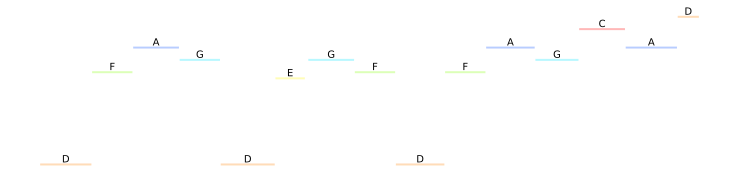

In [678]:
f = 'yamaha/notre_dame.wav'
plot_notes(f, 'b')
IPython.display.Audio(f)

Jonathan Coulton, "Still Alive" from _Portal_ soundtrack:

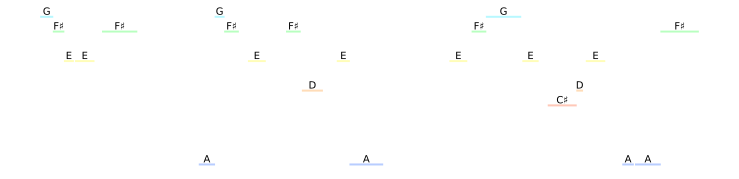

In [677]:
f = 'yamaha/portal.wav'
plot_notes(f, '#')
IPython.display.Audio(f)

A chromatic scale to test a range of notes:

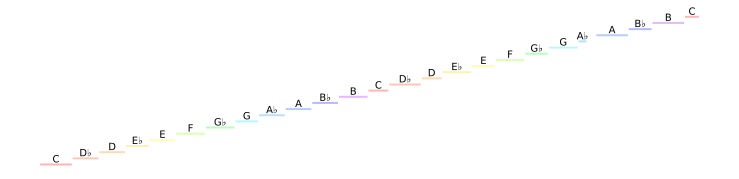

In [676]:
f = 'yamaha/fast.wav'
plot_notes(f, 'b')
IPython.display.Audio(f)

Mozart, Symphony No. 40, mvt. 1:

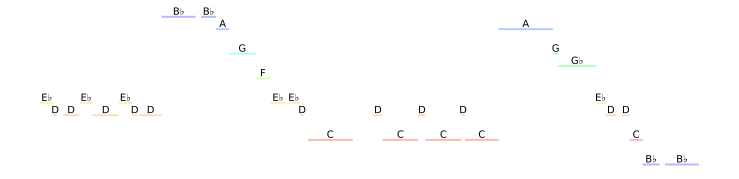

In [675]:
f = 'yamaha/mozart_s40.wav'
plot_notes(f, 'b')
IPython.display.Audio(f)